In [20]:
# from aerobot.plot import plot_training_curve
import os
from aerobot.io import load_results_dict, RESULTS_PATH, FEATURE_SUBTYPES, FEATURE_TYPES
import matplotlib.pyplot as plt
from aerobot.plot import plot_configure_mpl, plot_model_accuracy_barplot, plot_order_feature_types
from matplotlib.gridspec import GridSpec
from aerobot.dataset import dataset_load_training_validation
import pandas as pd 
import numpy as np 
from typing import Dict 

%load_ext autoreload
%autoreload 2

plot_configure_mpl(n_colors=3)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# SI Figure 2 

The second supplementary figure consists of three panels.

- Panel A: The final training and validation accuracies of the logistic classifiers applied for ternary classification. 
- Panel B: The final training and validation accuracies of the nonlinear classifiers applied for ternary classification. 
- Panel C: The final training and validation accuracies of the logistic classifiers applied for binary classification. 

The accuracy values can be represented as side-by-side bar plots, and the annotation-free versus annotation-based feature types should be colored differently. I think all feature types (not just the few selected for the main-text figure), should be displayed, although I should probably double-check. 


In [21]:
# Load the model training results. 
nonlinear_results_ternary = dict()
logistic_results_ternary = dict()
logistic_results_binary = dict()

for feature_type in FEATURE_SUBTYPES + FEATURE_TYPES:
    nonlinear_results_ternary[feature_type] = load_results_dict(os.path.join(RESULTS_PATH, f'train_nonlinear_{feature_type}_ternary.json'))
    logistic_results_ternary[feature_type] = load_results_dict(os.path.join(RESULTS_PATH, f'train_logistic_{feature_type}_ternary.json'))
    logistic_results_binary[feature_type] = load_results_dict(os.path.join(RESULTS_PATH, f'train_logistic_{feature_type}_binary.json'))

In [22]:
def plot_si_figure_2a(nonlinear_results_ternary:Dict, grid:GridSpec=None, fig:plt.Figure=None):  
    ax = fig.add_subplot(grid)

    order_by = {f:r['validation_acc'] for f, r in nonlinear_results_ternary.items()}
    feature_type_order = plot_order_feature_types(list(nonlinear_results_ternary.keys()), order_by=order_by)

    # Might be good to sort features on the bar plot according to validation accuracy. 
    plot_model_accuracy_barplot(nonlinear_results_ternary, ax=ax, feature_type_order=feature_type_order)

In [23]:
def plot_si_figure_2b(logistic_results_ternary:Dict, grid:GridSpec=None, fig:plt.Figure=None):
    ''''''
    ax = fig.add_subplot(grid)

    order_by = {f:r['validation_acc'] for f, r in logistic_results_ternary.items()}
    feature_type_order = plot_order_feature_types(list(logistic_results_ternary.keys()), order_by=order_by)

    # Might be good to sort features on the bar plot according to validation accuracy. 
    plot_model_accuracy_barplot(logistic_results_ternary, ax=ax, feature_type_order=feature_type_order)

In [24]:
def plot_si_figure_2c(logistic_results_binary:Dict, grid:GridSpec=None, fig:plt.Figure=None):
    ax = fig.add_subplot(grid)

    order_by = {f:r['validation_acc'] for f, r in logistic_results_binary.items()}
    feature_type_order = plot_order_feature_types(list(logistic_results_binary.keys()), order_by=order_by)

    # Might be good to sort features on the bar plot according to validation accuracy. 
    plot_model_accuracy_barplot(logistic_results_binary, ax=ax, feature_type_order=feature_type_order)

/tmp/ipykernel_171779/1722959562.py:8: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


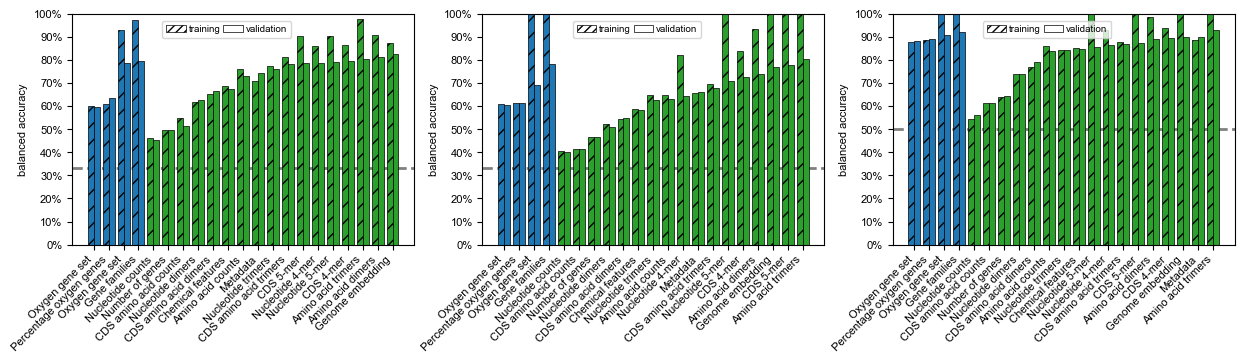

In [25]:
fig = plt.figure(figsize=(15, 3))
grid = GridSpec(1, 3, wspace=0.2, hspace=0.3)

plot_si_figure_2a(nonlinear_results_ternary, grid=grid[0, 0], fig=fig)
plot_si_figure_2b(logistic_results_ternary, grid=grid[0, 1], fig=fig)
plot_si_figure_2c(logistic_results_binary, grid=grid[0, 2], fig=fig)

plt.tight_layout()
plt.show()